In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

In [2]:
preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
print(preDouble)

\\iobsdc01\SharedDocs\SEER_MEDICARE\SEER_MEDICARE_STAGING


In [3]:
import pickle
fileObject = open('pure_control_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices = list(b)


In [4]:
import pickle
fileObject = open('pure_treatment_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices = list(b)


In [5]:
df = pd.read_pickle('dfpedsfFirsts.pickle')


In [6]:
dg = pd.read_pickle('pure_goodindices_medpar.pickle')

In [7]:
d_t_c = dict(zip(treatmentindices, controlindices))
d_c_t = dict(zip(controlindices, treatmentindices))

In [8]:
dgtreatment = dg[dg.patient_id.isin(treatmentindices)].copy()

dgcontrol = dg[dg.patient_id.isin(controlindices)].copy()

In [9]:

df = df.set_index('patient_id',drop=False)

In [10]:
goodindices = controlindices + treatmentindices
print(len(goodindices),len(controlindices),len(treatmentindices))

1662 831 831


In [11]:
df_all_good_indices = df.loc[goodindices].copy()

In [12]:
del df

In [13]:

monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}


df_all_good_indices['month1'] = df_all_good_indices['modx1'].replace(monthdict)

# <font color="#E56717">We need to only keep claims for which the date of admission is later in time than the cancer diagnosis date</font>

## Let's limit it just to prostate

In [14]:
#bad_month_indices_filter = df_all_good_indices['month1'].isnull()
prostate_filter = df_all_good_indices['site1'].str.contains('prostate',case=False,na=False)
to_drop = list(df_all_good_indices[~prostate_filter].site1.index)
print(to_drop)

['4482160083', '2215176050', '8859072472', '2310153070', '8802026371', '8757024520', '8831097343', '8878004314', '8827010107', '4408106073', '8797097489', '8835013250', '4339013024', '4304141320', '4326238080', '4269060013', '8848090384', '4268053014', '8797035478', '8841081424', '8868081313', '4339033024', '4222034004', '8735038409', '8716025459', '4462162024', '8821066343', '8858012304', '8845030491', '8841000365', '8888027441', '4313295000', '8825058106', '8888086461', '4473112043', '8714009560', '8870085471', '8819038335', '8885077334', '8865081345', '8815026310', '8889005430', '4454195034', '4247072024', '8851092441', '8897051314', '4295048060', '8852000315', '8875067360', '4315229060']


In [15]:
drop_set = set(to_drop)
t_set = set(d_t_c.keys())

lose_set = t_set.intersection(drop_set)
print(len(lose_set))


25


In [16]:
for i in list(lose_set):
    del d_t_c[i]

In [17]:
goodtreatmentindices = d_t_c.keys()
goodcontrolindices = d_t_c.values()
print(len(goodtreatmentindices), len(goodcontrolindices))

806 806


# Just including the prostate cancer patients now

In [18]:

df_all_good_indices = df_all_good_indices.loc[list(goodcontrolindices) + list(goodtreatmentindices)]

In [20]:
df_all_good_indices.month1.value_counts()

08    152
02    150
06    146
03    146
01    140
04    136
10    136
05    134
07    134
11    130
09    106
12     96
Name: month1, dtype: int64

In [21]:
df_all_good_indices.month1.iloc[0]

'05'

In [22]:
df_all_good_indices['newmonth1'] = df_all_good_indices.month1.fillna('01').copy()

In [23]:

df_all_good_indices['yrdx_plus_modx'] = df_all_good_indices.yrdx1.astype('str') + df_all_good_indices.newmonth1.astype('str')


df_all_good_indices['yrdx_plus_modx'] = pd.to_datetime(df_all_good_indices['yrdx_plus_modx'], 
                                                      format='%Y%m')

In [46]:
dg = dg.set_index('patient_id',drop=False)

In [50]:
dgtreatment = dg[dg.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dgcontrol = dg[dg.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

In [51]:
dgtreatment.shape

(1037, 171)

In [52]:
dgcontrol.shape

(1628, 171)

In [53]:
dg.shape

(2917, 171)

In [54]:
dgtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgtreatment['site1'] = df_all_good_indices['site1']

In [55]:
dgtreatment.shape

(1037, 173)

In [56]:
dgcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgcontrol['site1'] = df_all_good_indices['site1']

In [57]:
dgcontrol.shape

(1628, 173)

In [58]:
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date.astype('str').str.replace('\.0','')
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date_new.str.rjust(8,'0')

In [59]:
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date.astype('str').str.replace('\.0','')
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date_new.str.rjust(8,'0')

In [60]:
dgtreatment['medpar_admission_date_new'] = pd.to_datetime(dgtreatment['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

In [61]:
dgcontrol['medpar_admission_date_new'] = pd.to_datetime(dgcontrol['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

In [62]:
df_all_good_indices.shape

(1612, 499)

In [63]:
dgtreatment.head()

,registry,patient_id,age,stdstate,std_cnty,admday,dschgsta,ghopd,ppsind,provcode,...,outclrcde,primpayr,esrdcond,admsrce,admtype,admdxcde,deathadm,yrdx_plus_modx,site1,medpar_admission_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
8876036350,88,8876036350,77,5,430,2,A,NaN,2,NaN,...,0,NaN,0,7,2,6824,0,2006-05-01,Prostate gland,2006-04-23
8860084330,88,8860084330,70,5,430,5,A,NaN,2,NaN,...,0,NaN,0,1,3,4139,0,2006-01-01,Prostate gland,2006-12-06
8881015430,88,8881015430,75,5,460,2,A,NaN,2,NaN,...,0,NaN,0,7,1,35800,0,2010-02-01,Prostate gland,2006-10-08
8881015430,88,8881015430,75,5,460,5,A,NaN,2,NaN,...,2,NaN,0,7,1,51881,0,2010-02-01,Prostate gland,2006-10-25
8881015430,88,8881015430,75,5,460,7,A,NaN,2,NaN,...,0,NaN,0,1,2,35801,0,2010-02-01,Prostate gland,2006-12-15


In [64]:
dgcontrol.head()

,registry,patient_id,age,stdstate,std_cnty,admday,dschgsta,ghopd,ppsind,provcode,...,outclrcde,primpayr,esrdcond,admsrce,admtype,admdxcde,deathadm,yrdx_plus_modx,site1,medpar_admission_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
8844065341,88,8844065341,67,5,650,7,A,NaN,2,NaN,...,0,NaN,0,7,2,85220,0,2007-02-01,Prostate gland,2006-11-03
8842059335,88,8842059335,74,5,640,6,A,NaN,2,NaN,...,0,NaN,0,1,2,78609,0,2009-08-01,Prostate gland,2006-06-22
8890073491,88,8890073491,71,5,200,5,A,NaN,2,NaN,...,0,NaN,0,7,1,7802,0,2011-04-01,Prostate gland,2006-01-04
4422191074,44,4422191074,65,31,260,2,A,NaN,2,NaN,...,0,NaN,0,7,1,4280,1200,2008-05-01,Prostate gland,2006-08-13
8890067390,88,8890067390,75,5,400,3,A,NaN,2,NaN,...,0,NaN,0,7,2,2989,0,2006-05-01,Prostate gland,2006-11-06


# <font color="#E56717">Hospital Data</font>

* <span style="font-size:1.5em;">MedPAR: Medicare Provider and Review</span>
* <span style="font-size:1.5em;">One record per stay</span>
* <span style="font-size:1.5em;">Key elements: admission and discharge diagnoses and dates, procedures and procedure dates, revenue center codes for ER,etc.</span>
* <span style="font-size:1.5em;">Reports facility charges only</span>
* <span style="font-size:1.5em;">Paid by DRG (diagnostic review group) which is based on diagnoses and procedures</span>


# <font color="#E56717">Cost-related variables</font>

* <span style="font-size:1.5em;">Charges (what the hospital asked to be paid</span>
* <span style="font-size:1.5em;">What the hospital was paid: amount reimbursed PLUS bill total per diem</span>
* <span style="font-size:1.5em;">Deductibles</span>
* <span style="font-size:1.5em;">Primary Payer amount</span>

<span style="font-size:1.5em;">Medicare determines what the provider is allowed to charge for a service ('allowed charges'). Payment of the allowed charges come from two sources:</span>

* <span style="font-size:1.5em;">Medicare</span>
* <span style="font-size:1.5em;">Beneficiary: Co-payments, coinsurance, and deductibles (may be paid by coinsurance such as Medigap)</span>

* <span style="font-size:1.5em;">Hospitals have per-stay deductibles and co-payments</span>


# <font color="#E56717">Trying to figure out MedPAR payments</font>

* <span style="font-size:1.5em;">Total payments from Medicare are calculated as reimbursement amount PLUS total pass through amount</span>
* <span style="font-size:1.5em;">Primary payer amount is the amount paid by another insurance (before Medicare)</span>
* <span style="font-size:1.5em;">Total payments: need to add together Medicare payments, primary payer amount and copayment/deductible</span>


# <font color="#E56717">Use these fields in the MedPAR file</font>

* <span style="font-size:1.5em;">COINAMT - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for part A coinsurance for the stay</span> 
* <span style="font-size:1.5em;">INPATDED - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for inpatient deductible for the stay</span>
* <span style="font-size:1.5em;">BLOODDED - The amounf of money (rounded to whole dollars) identified as the beneficiary's liability for the blood deductible for the stay</span>
* <span style="font-size:1.5em;">PRIPYAMT - The amount of payment (rounded to whole dollars) made on behalf of the beneficiary by a primary payer other than Medicare, which has been applied to the covered Medicare charges for the stay</span>
* <span style="font-size:1.5em;">DISHRAMT - The amount paid over the DRG amount (rounded to whole dollars) for the disproportionate share hospital for the stay</span>
* <span style="font-size:1.5em;">INDMEDED - The amount of additional payment (rounded to whole dollars) made to teaching hospitals for IME for the stay</span>
* <span style="font-size:1.5em;">DRGPRICE - The amount (called the DRG price) that would have been paid if no deductibles, coinsurance, primary payers, or outliers were involved (rounded to whole dollars)</span>
* <span style="font-size:1.5em;">PASSTHRU - The total of all claim pass through amounts (rounded to whole dollars) for the stay.</span>
* <span style="font-size:1.5em;">REIMBAMT - Amount of payment made from the Medicare trust fund for the services covered by the claim record</span>

In [66]:
list(dgcontrol.columns)

['registry',
 'patient_id',
 'age',
 'stdstate',
 'std_cnty',
 'admday',
 'dschgsta',
 'ghopd',
 'ppsind',
 'provcode',
 'snfind',
 'numbills',
 'latest_claim_accretion_date',
 'benefit_exhausted_date',
 'qualification_from_date',
 'qualification_through_date',
 'medpar_admission_date',
 'medpar_discharge_date',
 'bene_death_date',
 'cvr_through_date',
 'himasind',
 'los',
 'outlrday',
 'cvrddays',
 'coindays',
 'lifresdy',
 'coinamt',
 'inpatded',
 'bloodded',
 'pripyamt',
 'outlramt',
 'dishramt',
 'indmeded',
 'drgprice',
 'passthru',
 'low_pamt',
 'totchrgs',
 'cvrdchrg',
 'reimbamt',
 'totacchr',
 'totdpchr',
 'incrdays',
 'crcrdays',
 'incrchrg',
 'crcrchrg',
 'phrmchrg',
 'phytchrg',
 'ocptchrg',
 'spptchrg',
 'inhtchrg',
 'blddchrg',
 'bladchrg',
 'oprtchrg',
 'lithchrg',
 'cardchrg',
 'anstchrg',
 'labrchrg',
 'radichrg',
 'opsrchrg',
 'mrichrg',
 'emrmchrg',
 'amblchrg',
 'proffees',
 'oraqchrg',
 'esrdchrg',
 'clvtchrg',
 'increind',
 'crcreind',
 'phrmyind',
 'trnspind',
 '

In [73]:
dgcontrol['total_amt'] = dgcontrol['coinamt'] + dgcontrol['inpatded'] + \
dgcontrol['bloodded'] + dgcontrol['pripyamt'] +  \
dgcontrol['indmeded'] + dgcontrol['passthru'] + \
dgcontrol['reimbamt']

In [74]:
dgtreatment['total_amt'] = dgtreatment['coinamt'] + dgtreatment['inpatded'] + \
dgtreatment['bloodded'] + dgtreatment['pripyamt'] + \
dgtreatment['indmeded'] + dgtreatment['passthru'] + \
dgtreatment['reimbamt']

In [75]:
goodcols = ['medpar_admission_date_new','yrdx_plus_modx','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [76]:
dgcontrol[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,
8844065341,2006-11-03,2007-02-01,13309,0,952,0,0,0,0,12357
8842059335,2006-06-22,2009-08-01,5920,0,952,0,0,0,0,4968
8890073491,2006-01-04,2011-04-01,6248,0,952,0,0,187,0,5109
4422191074,2006-08-13,2008-05-01,7616,0,952,0,0,388,0,6276
8890067390,2006-11-06,2006-05-01,4936,0,952,0,0,0,0,3984


In [77]:
dgtreatment[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,
8876036350,2006-04-23,2006-05-01,3324,0,952,0,0,0,0,2372
8860084330,2006-12-06,2006-01-01,13399,0,952,0,0,0,0,12447
8881015430,2006-10-08,2010-02-01,9823,0,952,0,0,1028,0,7843
8881015430,2006-10-25,2010-02-01,47396,0,0,0,0,1526,0,45870
8881015430,2006-12-15,2010-02-01,9823,0,0,0,0,1028,0,8795


# <font color="#E56717">Now restrict to those claims where medpar_admission_date_new is later in time than yrdx_plus_modx</font>

In [82]:
dgtreatment['time_delta'] = dgtreatment['medpar_admission_date_new'] - dgtreatment['yrdx_plus_modx']

dgcontrol['time_delta'] = dgcontrol['medpar_admission_date_new'] - dgcontrol['yrdx_plus_modx']


In [83]:
def make_days(i):
    return i.days

In [85]:
dgtreatment['delta_days'] = dgtreatment['time_delta'].apply(make_days)
dgcontrol['delta_days'] = dgcontrol['time_delta'].apply(make_days)

In [86]:
goodcols = ['medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [87]:
dgtreatment[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8876036350,2006-04-23,2006-05-01,-8 days,-8,3324,0,952,0,0,0,0,2372
8860084330,2006-12-06,2006-01-01,339 days,339,13399,0,952,0,0,0,0,12447
8881015430,2006-10-08,2010-02-01,-1212 days,-1212,9823,0,952,0,0,1028,0,7843
8881015430,2006-10-25,2010-02-01,-1195 days,-1195,47396,0,0,0,0,1526,0,45870
8881015430,2006-12-15,2010-02-01,-1144 days,-1144,9823,0,0,0,0,1028,0,8795


In [88]:
dgcontrol[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8844065341,2006-11-03,2007-02-01,-90 days,-90,13309,0,952,0,0,0,0,12357
8842059335,2006-06-22,2009-08-01,-1136 days,-1136,5920,0,952,0,0,0,0,4968
8890073491,2006-01-04,2011-04-01,-1913 days,-1913,6248,0,952,0,0,187,0,5109
4422191074,2006-08-13,2008-05-01,-627 days,-627,7616,0,952,0,0,388,0,6276
8890067390,2006-11-06,2006-05-01,189 days,189,4936,0,952,0,0,0,0,3984


In [90]:
good_claims_filter_treatment = dgtreatment.delta_days > 0
good_claims_filter_control = dgcontrol.delta_days > 0

In [92]:
dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

In [93]:
dgtreatmentgoodclaims[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8860084330,2006-12-06,2006-01-01,339 days,339,13399,0,952,0,0,0,0,12447
8899006269,2006-02-18,2006-01-01,48 days,48,5432,0,952,0,0,0,0,4480
8884030330,2006-09-25,2006-04-01,177 days,177,5851,0,952,0,0,635,0,4264
8827052320,2006-10-24,2006-04-01,206 days,206,15408,0,952,0,0,0,0,14456
8827052320,2006-10-22,2006-04-01,204 days,204,3554,0,0,0,0,0,0,3554


In [94]:
dgcontrolgoodclaims[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8890067390,2006-11-06,2006-05-01,189 days,189,4936,0,952,0,0,0,0,3984
8806031320,2006-06-08,2006-02-01,127 days,127,34370,0,952,0,0,6850,0,26568
8806031320,2006-06-27,2006-02-01,146 days,146,34739,0,0,0,0,3880,0,30859
8865083320,2006-08-14,2006-01-01,225 days,225,10682,0,952,0,0,0,0,9730
8809018330,2006-02-07,2006-02-01,6 days,6,13375,0,0,0,0,0,0,13375


In [95]:
dgtreatment['srvm1'] = df_all_good_indices['srvm1']

In [96]:
dgcontrol['srvm1'] = df_all_good_indices['srvm1']

In [97]:
dgtreatment.shape

(1037, 178)

In [98]:
def make_months(i):
    return int(i.days/30)

In [99]:
dgtreatment['delta_months'] = dgtreatment['time_delta'].apply(make_months)
dgcontrol['delta_months'] = dgcontrol['time_delta'].apply(make_months)

In [112]:
goodcols = ['patient_id','medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days',
            'delta_months','srvm1','total_amt','los',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [113]:
dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

In [114]:
dgtreatmentgoodclaims[goodcols].head()

,patient_id,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,delta_months,srvm1,total_amt,los,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,,,,,
8860084330,8860084330,2006-12-06,2006-01-01,339 days,339,11,77,13399,1,0,952,0,0,0,0,12447
8899006269,8899006269,2006-02-18,2006-01-01,48 days,48,1,74,5432,1,0,952,0,0,0,0,4480
8884030330,8884030330,2006-09-25,2006-04-01,177 days,177,5,80,5851,2,0,952,0,0,635,0,4264
8827052320,8827052320,2006-10-24,2006-04-01,206 days,206,6,78,15408,2,0,952,0,0,0,0,14456
8827052320,8827052320,2006-10-22,2006-04-01,204 days,204,6,78,3554,1,0,0,0,0,0,0,3554


In [115]:
a = dgtreatmentgoodclaims.delta_months - dgtreatmentgoodclaims.srvm1
a.describe()

count    815.000000
mean     -16.807362
std       21.508491
min      -82.000000
25%      -31.000000
50%      -13.000000
75%        0.000000
max       18.000000
dtype: float64

# <font color="#E56717">In the plot below, the 20% of patients with claims at a date further in the future than the followup time survival months in the SEER piece must be the 2011 DX patients and their 2011, 2012, and 2013 claims. Makes sense; so let's just look at all claims after the DX</font>

# 80% of the claims are prior to the listed the dx date plus survival months

In order to capture the costs of those patients who were diagnosed write at the end of 2011 (and so have low, censored values of srvm1), we need to just include all claims after the dx date

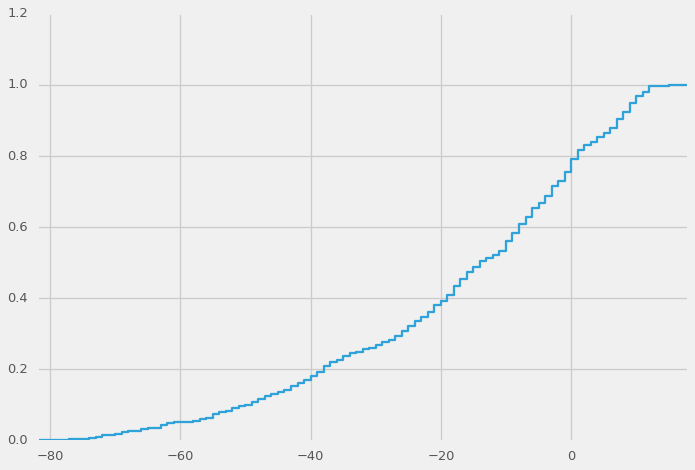

In [116]:
a.value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps')

# <font color="#E56717">Not all patients are in the MEdpar file, but all are in the NCH file concatenated with the OUTSAF file; we can perform a paired test to see if there are statistically significant differences after getting the analog of total_amt for those two files and concatenating with this medpar result</font>


# For now, let's just look at the CDFs of the tot_amt grouped for each patient (a patient may have more than one stay). Do the same for 'los': length of stay in days

In [117]:
dgmedpartreatmentgroup = dgtreatmentgoodclaims.groupby('patient_id')

In [118]:
dgmedparcontrolgroup = dgcontrolgoodclaims.groupby('patient_id')

In [126]:
treatmentmedparagg = dgmedpartreatmentgroup[['total_amt','los']].agg(np.sum)

In [127]:
controlmedparagg = dgmedparcontrolgroup[['total_amt','los']].agg(np.sum)

In [128]:
treatmentmedparagg.head()

,total_amt,los
patient_id,,
0231464080,5736,2
0247481030,34517,10
0274414060,28452,12
2136138000,0,1
2225043505,56790,39


In [129]:
treatmentmedparagg.shape

(327, 2)

In [130]:
controlmedparagg.shape

(451, 2)

In [131]:
treatmentmedparagg.describe()

,total_amt,los
count,327.000000,327.000000
mean,36400.639144,15.345566
std,47866.040142,27.008403
min,0.000000,1.000000
25%,9163.000000,2.000000
50%,20634.000000,5.000000
75%,44371.000000,15.500000
max,480172.000000,254.000000


In [133]:
controlmedparagg.describe() # a big outlier    lets look at the CDFS

,total_amt,los
count,4.510000e+02,451.000000
mean,4.071565e+04,18.611973
std,9.765959e+04,40.945033
min,0.000000e+00,1.000000
25%,9.031500e+03,3.000000
50%,2.049000e+04,6.000000
75%,4.363300e+04,18.000000
max,1.853452e+06,468.000000


(0, 200000)

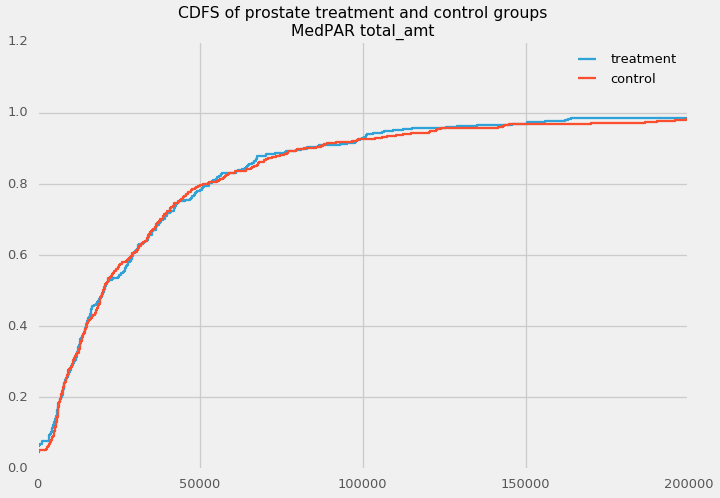

In [136]:
at = treatmentmedparagg.total_amt.value_counts(normalize=True).sort_index().cumsum()
ac = controlmedparagg.total_amt.value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control')
plt.legend()
plt.title('CDFS of prostate treatment and control groups\nMedPAR total_amt')
plt.xlim(0,200000)

(0, 300)

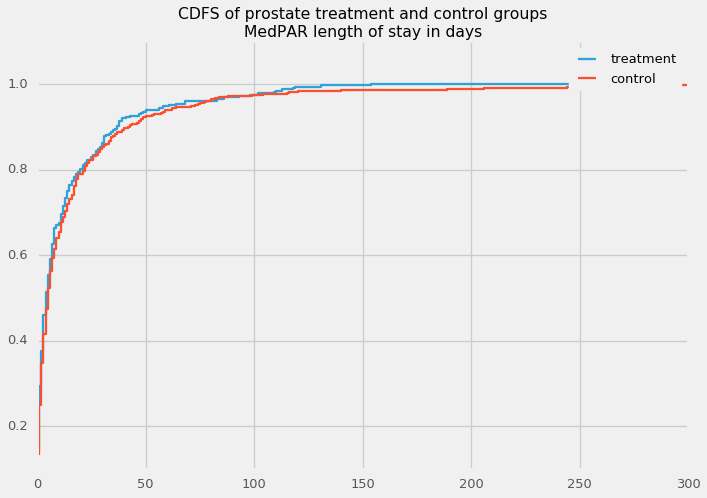

In [138]:
at = treatmentmedparagg.los.value_counts(normalize=True).sort_index().cumsum()
ac = controlmedparagg.los.value_counts(normalize=True).sort_index().cumsum()
ax = at.plot(drawstyle='steps',label='treatment')
ac.plot(drawstyle='steps',label='control')
plt.legend()
plt.title('CDFS of prostate treatment and control groups\nMedPAR length of stay in days')
plt.xlim(0,300)

In [139]:
from scipy import stats

In [140]:
stats.ks_2samp(treatmentmedparagg.los.as_matrix(),
              controlmedparagg.los.as_matrix())

Ks_2sampResult(statistic=0.049417875329712535, pvalue=0.7332262629635794)

In [141]:
stats.ks_2samp(treatmentmedparagg.total_amt.as_matrix(),
              controlmedparagg.total_amt.as_matrix())

Ks_2sampResult(statistic=0.033632363012537539, pvalue=0.98110084171196255)

# <font color="#E56717">Outpatient Claims from Facilities</font>

* <span style="font-size:1.5em;">Care that is provided by hospitals on an outpatient basis is found in the outpatient file</span>
* <span style="font-size:1.5em;">The billing form (UB-92) used for inpatient hospitalizations is also used for hospital outpatient, skilled nursing facility, home health and hospice claims</span>
* <span style="font-size:1.5em;">Examples of such are include:</span>
    * <span style="font-size:1.5em;">Day surgery</span>
    * <span style="font-size:1.5em;">Therapeutic radiology</span>
    * <span style="font-size:1.5em;">ER not resulting in an inpatient admission</span>

# <font color="#E56717">Structure of Outpatient Data</font>

* <span style="font-size:1.5em;">The outpatient data are structured differently than the MedPAR even though they are both derived from facility claims. In the outpatient, there is a summary record with revenue center code of 0001 for each bill.</span>
* <span style="font-size:1.5em;">There is also one record for each recenue center code listed on the claim (and associated detail)</span>
    * <span style="font-size:1.5em;">these are not rolled up or combined in any way;</span>
    * <span style="font-size:1.5em;">revenue center codes can repeat on a single claim</span>
* <span style="font-size:1.5em;">All records from a partciular claim include the same non-revenue center-level detail</span>
    * <span style="font-size:1.5em;">Therefore, a bill with one revenue center code would have two records in a file - a summary and the one for the single revenue center</span>
    * <span style="font-size:1.5em;">a bill with 10 revenue center codes would have 11 records in the file - the summary and the 10 specific codes. The basic information about claim from - claim through, total payments, etc. would be repeated 11 times</span>

# <font color="#E56717">Variables that researchers often use in the Hospital Outpatient file</font>

* <span style="font-size:1.5em;">Provder information</span>
    * <span style="font-size:1.5em;">Hospital number (encrypted) - first 2 digits are the state where the hospital is located</span>
    * <span style="font-size:1.5em;">Identify of physican providing care (encrypted)</span>
* <span style="font-size:1.5em;">Date of service started and stopped - this can be a single day or a span of days</span>
* <span style="font-size:1.5em;">Diagnosis codes</span>
* <span style="font-size:1.5em;">Procedure codes:</span>
    * <span style="font-size:1.5em;">HCPCS codes for the services provided linked to a revenue center code</span>
    * <span style="font-size:1.5em;">ICD-9 procedure codes - used previously, phased out, not used for current billing</span>
* <span style="font-size:1.5em;">Total charges and reimbursement</span>

# <font color="#E56717">Payments in the Outpatient file</font>

* <span style="font-size:1.5em;">Payments in the Outpatient file are based on service, referred to as "Revenue Centers." This is similar to line items</span>
* <span style="font-size:1.5em;">Each line in the Outpatient file is a "Revenue Center" within a claim. Each claim contains at least two records, one of which is a summary record. The Summary record contains Revenue Center = 0001</span>
* <span style="font-size:1.5em;">For services on or after July 2000, the Outpatient file contains Revenue center payments. Before then, the file contained claim payments only.</span>


# <font color="#E56717">Revenue Center Payment by Medicare</font>
* <span style="font-size:1.5em;">Revenue Center Payment Amount (Revenue Center = 0001 record will contain $0.000)</span>

# <font color="#E56717">Revenue Center beneficiary responsibility:</font>
* <span style="font-size:1.5em;">2012 link: Revenue Center Patient Responsiblity Payment Amount; earlier linkage years: not available</span>

# <font color="#E56717">Total Claim Payment by Medicare:</font>
* <span style="font-size:1.5em;">2012 link: Claim Payment Amount</span>
    * <span style="font-size:1.5em;">This repeats on every line; be careful not to double count</span>
* <span style="font-size:1.5em;">Earlier linkages: Claim Payment Amount, but only when record count field = '0001' - all other lines = $0</span>

# <font color="#E56717">Total Beneficiary responsibility</font>

<span style="font-size:1.5em;">Beneficiary Part B Deductible Amount + Beneficiary Part B Coninsurance Amount + NCH Beneficiary Blood Deductible Amount</span>

# <font color="#E56717">Total Payment due to Provider:</font>

<span style="font-size:1.5em;"> Medicare Payment + Beneficiary Responsbility + Primary Payer Claim Paid Amount</span>

# <font color="#E56717">Beneficiary Responsibility</font>

* <span style="font-size:1.5em;">Beneficiary co-payment and deductible fields contain the amount the beneficiary owes. It does not contain the amount that the beneficiary actually paid</span>
* <span style="font-size:1.5em;">There is no way to determine how much of the beneficiary resonsibliity was actually paid to the provider</span>
* <span style="font-size:1.5em;">There is also no way to determine whether the beneficiary ahd other coverage (e.g. Medigap, Medicaid) that paid part or all of the beneficiary's responsibility</span>

# <font color="#E56717">Will need these columns from the outsaf file:</font>

* <span style="font-size:1.5em;">patient_id, claim_from_date, claim_trough_date, state_cd, cnty_cd</span>

* <span style="font-size:1.5em;">pmt_amt: Made to Provider and/or Beneficiary from trust fund (after deductible and coinsurance amounts) for services covered by Institutional claim (does not include pass-through per diem or organ acquisition), or for Physician/Supplier claim. Does not include automatic adjustments. NOTE: If more than one record from the same claim (sorted by Patient ID, Claim From Date, Linknum, and Rec_Count) is selected, be sure to keep the claim payment amount from the first record only   (Will need to contruct a composite primary key to ID distinct claims)</span>

* <span style="font-size:1.5em;">prpayamt</span>
* <span style="font-size:1.5em;">tot_line</span>
* <span style="font-size:1.5em;">seg_line</span>
* <span style="font-size:1.5em;">oprevcnt</span>
* <span style="font-size:1.5em;">center - Cost center (division or unit within a hospital) for which a separate charge is billed (type of accommodation or ancillary). Assigned by provider. (Refer to appendix table CEN)</span>
* <span style="font-size:1.5em;">revdctbl - The amount of cash deductible the beneficiary paid for the line item service</span>
* <span style="font-size:1.5em;">wageadj - The amount of coinsurance applicable to the line item service defined by the revenue center and HCPCS codes. For those services subject to Outpatient PPS, the applicable coinsurance is wage adjusted</span>
* <span style="font-size:1.5em;">rev_msp1 - The amount paid by the primary payer when the payer is primary to Medicare (Medicare is secondary)</span>
* <span style="font-size:1.5em;">rprvdpmt - The amount paid to the provider for the services reported on the line item</span>
* <span style="font-size:1.5em;">ptntresp - The amount paid by the beneficary to the provider for the line item service</span>
* <span style="font-size:1.5em;">pay - Medicare payment amount for the specific revenue center</span>
* <span style="font-size:1.5em;">link_num - A system generated by CMS; number used to keep records/segments belonging to a specific claim together. Use in conjuction with the Claim From Date to identify a specific claim</span>
* <span style="font-size:1.5em;">tot_seg - Total number of segments for each claim (corresponds to total number of original var-length recs for each claim. Max = 10)</span>
* <span style="font-size:1.5em;">seg_num - Number of each segment (corresponds to the orignal var-length record for this claim. Values: 1 to 10)</span>
* <span style="font-size:1.5em;">rec_count - Counter for each claim</span>
* <span style="font-size:1.5em;">ptb_ded - Beneficiary's liability for Part B cash deductible as determined by intermediary or Carrier</span>
* <span style="font-size:1.5em;">ptb_coin - Beneficiary's liability for Part B coinsurance as determined by intermediary</span>
* <span style="font-size:1.5em;">blddedam - The amount of money for which the intermediary determined the beneficiary is liable for the blood deductible.</span>
* <span style="font-size:1.5em;">prvdrpmt - The amount paid, from the Medicare trust fund, to the provider for the services reported on the outpatient claim</span>


In [142]:
dh = pd.read_pickle('pure_goodindices_outsaf.pickle')

In [143]:
dh = dh.set_index('patient_id', drop=False)

In [144]:
dhtreatment = dh[dh.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dhcontrol = dh[dh.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

In [145]:
dhtreatment.shape

(172767, 98)

In [146]:
dhcontrol.shape

(168014, 98)

In [147]:
dhtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dhtreatment['site1'] = df_all_good_indices['site1']

In [148]:
dhtreatment.shape

(172767, 100)

In [149]:
dhcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dhcontrol['site1'] = df_all_good_indices['site1']

In [150]:
dhcontrol.shape

(168014, 100)

In [152]:
dhtreatment['claim_from_date_new'] = dhtreatment.claim_from_date.astype('str').str.replace('\.0','')
dhtreatment['claim_from_date_new'] = dhtreatment.claim_from_date_new.str.rjust(8,'0')

dhtreatment['claim_through_date_new'] = dhtreatment.claim_through_date.astype('str').str.replace('\.0','')
dhtreatment['claim_through_date_new'] = dhtreatment.claim_through_date_new.str.rjust(8,'0')




In [153]:
dhcontrol['claim_from_date_new'] = dhcontrol.claim_from_date.astype('str').str.replace('\.0','')
dhcontrol['claim_from_date_new'] = dhcontrol.claim_from_date_new.str.rjust(8,'0')

dhcontrol['claim_through_date_new'] = dhcontrol.claim_through_date.astype('str').str.replace('\.0','')
dhcontrol['claim_through_date_new'] = dhcontrol.claim_through_date_new.str.rjust(8,'0')

In [154]:
dhtreatment['claim_from_date_new'] = pd.to_datetime(dhtreatment['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dhtreatment['claim_through_date_new'] = pd.to_datetime(dhtreatment['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

In [155]:
dhcontrol['claim_from_date_new'] = pd.to_datetime(dhcontrol['claim_from_date_new'], 
                                                      format='%m%d%Y').copy()

dhcontrol['claim_through_date_new'] = pd.to_datetime(dhcontrol['claim_through_date_new'], 
                                                      format='%m%d%Y').copy()

In [156]:
dhtreatment.head()

,registry,patient_id,state_cd,cnty_cd,clm_type,claim_from_date,claim_through_date,query_cd,fac_type,nopay_cd,...,edgnsd3,edgnsd4,edgnsd5,edgnsd6,prcdr_cd1,proc_performed_date,yrdx_plus_modx,site1,claim_from_date_new,claim_through_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
0247481030,2,0247481030,7,40,40,2152006,2152006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-08-01,Prostate gland,2006-02-15,2006-02-15
0247481030,2,0247481030,7,40,40,2152006,2152006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2007-08-01,Prostate gland,2006-02-15,2006-02-15
0231464080,2,0231464080,7,0,40,12192006,12192006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-01,Prostate gland,2006-12-19,2006-12-19
0231464080,2,0231464080,7,0,40,12192006,12192006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-01,Prostate gland,2006-12-19,2006-12-19
0231464080,2,0231464080,7,0,40,12192006,12192006,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2006-09-01,Prostate gland,2006-12-19,2006-12-19


# <font color="#E56717">Now restrict to those claims where claim_from_date_new is later in time than yrdx_plus_modx</font>

In [157]:
dhtreatment['time_delta'] = dhtreatment['claim_from_date_new'] - dhtreatment['yrdx_plus_modx']

dhcontrol['time_delta'] = dhcontrol['claim_from_date_new'] - dhcontrol['yrdx_plus_modx']

In [158]:
dhtreatment['delta_days'] = dhtreatment['time_delta'].apply(make_days)
dhcontrol['delta_days'] = dhcontrol['time_delta'].apply(make_days)

In [205]:
goodcols = ['claim_from_date_new','yrdx_plus_modx','tot_seg','delta_days','patient_id','claim_from_date',
           'link_num','rec_count','center','pmt_amt','prpayamt',
           'ptntresp','rprvdpmt','pay','ptb_ded','ptb_coin',
           'blddedam','prvdrpmt']

In [206]:
dhtreatment[goodcols].head(30)

,claim_from_date_new,yrdx_plus_modx,tot_seg,delta_days,patient_id,claim_from_date,link_num,rec_count,center,pmt_amt,prpayamt,ptntresp,rprvdpmt,pay,ptb_ded,ptb_coin,blddedam,prvdrpmt
patient_id,,,,,,,,,,,,,,,,,,
0247481030,2006-02-15,2007-08-01,1,-532,0247481030,2152006,1852683,1,310,72.06,0.0,48.04,72.06,72.06,0.0,48.04,0.0,72.06
0247481030,2006-02-15,2007-08-01,1,-532,0247481030,2152006,1852683,2,1,72.06,0.0,0.00,0.00,0.00,0.0,48.04,0.0,72.06
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,1,250,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,2,710,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,3,750,385.23,0.0,221.72,385.23,385.23,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,4,1,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-02-07,2006-09-01,1,-206,0231464080,2072006,1611463,1,250,1566.91,0.0,0.00,0.00,0.00,0.0,569.63,0.0,1566.91
0231464080,2006-02-07,2006-09-01,1,-206,0231464080,2072006,1611463,2,258,1566.91,0.0,0.00,0.00,0.00,0.0,569.63,0.0,1566.91
0231464080,2006-02-07,2006-09-01,1,-206,0231464080,2072006,1611463,3,270,1566.91,0.0,0.00,0.00,0.00,0.0,569.63,0.0,1566.91


In [207]:
dhcontrol[goodcols].head(10)

,claim_from_date_new,yrdx_plus_modx,tot_seg,delta_days,patient_id,claim_from_date,link_num,rec_count,center,pmt_amt,prpayamt,ptntresp,rprvdpmt,pay,ptb_ded,ptb_coin,blddedam,prvdrpmt
patient_id,,,,,,,,,,,,,,,,,,
0238421020,2006-05-17,2006-05-01,1,16,0238421020,5172006,1459255,1,314,191.02,0.0,127.35,191.02,191.02,0.0,127.35,0.0,191.02
0238421020,2006-05-17,2006-05-01,1,16,0238421020,5172006,1459255,2,1,191.02,0.0,0.00,0.00,0.00,0.0,127.35,0.0,191.02
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,1,333,2736.18,0.0,48.44,72.67,72.67,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,2,333,2736.18,0.0,48.44,72.67,72.67,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,3,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,4,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,5,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,6,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18
0238421020,2006-11-01,2006-05-01,1,184,0238421020,11012006,1515022,7,333,2736.18,0.0,74.91,299.63,299.63,0.0,744.59,0.0,2736.18


In [167]:
good_claims_filter_treatment = dhtreatment.delta_days > 0
good_claims_filter_control = dhcontrol.delta_days > 0

In [168]:
dhtreatmentgoodclaims = dhtreatment[good_claims_filter_treatment].copy()
dhcontrolgoodclaims = dhcontrol[good_claims_filter_control].copy()

In [209]:
dhtreatmentgoodclaims[goodcols].head()

,claim_from_date_new,yrdx_plus_modx,tot_seg,delta_days,patient_id,claim_from_date,link_num,rec_count,center,pmt_amt,prpayamt,ptntresp,rprvdpmt,pay,ptb_ded,ptb_coin,blddedam,prvdrpmt
patient_id,,,,,,,,,,,,,,,,,,
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,1,250,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,2,710,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,3,750,385.23,0.0,221.72,385.23,385.23,0.0,221.72,0.0,385.23
0231464080,2006-12-19,2006-09-01,1,109,0231464080,12192006,1271619,4,1,385.23,0.0,0.00,0.00,0.00,0.0,221.72,0.0,385.23
2225043505,2006-09-01,2006-04-01,1,153,2225043505,9012006,2008460,1,333,16207.50,0.0,45.40,68.12,68.12,0.0,4193.82,0.0,16207.50


In [173]:
dhtreatmentgoodclaims['prpayamt'].describe()

count    149572.000000
mean         84.108343
std        1895.235368
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       64840.000000
Name: prpayamt, dtype: float64

In [174]:
dhcontrolgoodclaims['prpayamt'].describe()

count    141395.000000
mean         78.835990
std        1470.219797
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       50422.640000
Name: prpayamt, dtype: float64

# <font color="#E56717">Create a claim_id field (a primary key for specific claims) by combining patient_id, claim_from_date, and link_num (all as one big string)</font>

In [215]:
type(dhtreatmentgoodclaims.patient_id[0]), type(dhtreatmentgoodclaims.claim_from_date_new.astype('str')[0])

(str, str)

In [217]:
type(dhtreatmentgoodclaims.link_num.astype('str')[0])

str

In [219]:
a = dhtreatmentgoodclaims.patient_id + dhtreatmentgoodclaims.claim_from_date_new.astype('str') + \
dhtreatmentgoodclaims.link_num.astype('str')

dhtreatmentgoodclaims['claim_id'] = a

In [220]:
a = dhcontrolgoodclaims.patient_id + dhcontrolgoodclaims.claim_from_date_new.astype('str') + \
dhcontrolgoodclaims.link_num.astype('str')

dhcontrolgoodclaims['claim_id'] = a

In [239]:
goodcols = ['claim_from_date_new','yrdx_plus_modx','claim_id','patient_id',
           'link_num','rec_count','center','pmt_amt','ptb_coin','ptb_ded','blddedam','rev_msp1']

# <font color="#E56717">Payments in the Outpatient file</font>

* <span style="font-size:1.5em;">Payments in the Outpatient file are based on service, referred to as 'Revenue Centers.' This is akin to Line items</span>
* <span style="font-size:1.5em;">Each line in the Outpatient file is a 'Revenue Center' within a claim. Each claim contains at least two records, one of which is a summary record. Summary records contain Revenue Center (center) = 1</span>

* <span style="font-size:1.5em;">For services on or after July 2000, the Outpatient file contains Revenue Center payments (rprvdmpt). Prior to that, the file contained total claim payments only (pmt_amt)</span>

# <font color="#E56717">Revenue Center payment by Medicare:</font>
* <span style="font-size:1.5em;">pay</span>

# <font color="#E56717">Revenue Center beneficiary responsibility</font>
* <span style="font-size:1.5em;">not available all years, ptntresp</span>

# <font color="#E56717">The amount paid to the provider for the services reported on the line item</font>
* <span style="font-size:1.5em;">rprvdpmt</span>

# <font color="#E56717">Total Claim Payment by Medicare</font>
<span style="font-size:1.5em;">pmt_amt - This repeats on every line; be careful to only count it once</span>

# <font color="#E56717">Total Beneficiary reponsibility:</font>
* <span style="font-size:1.5em;">Beneficiary Part B deductible Amount: ptb_ded</span>
* <span style="font-size:1.5em;">Beneficiary Part B Coinsurance Amount: ptb_coin</span>
* <span style="font-size:1.5em;">NCH Beneficiary Blood Deductible Amount: blddedam</span>



# <font color="#E56717">Total Payment due to Provider:</font>

* <span style="font-size:1.5em;">Medicare Payment = pmt_amt</span>
* <span style="font-size:1.5em;">Beneficiary responsibility: ptb_ded + ptb_coin + blddedam (do these vary by each record in the claim or not? I think so; in which case we need to sum over them for all records in the claim</span>
* <span style="font-size:1.5em;">Primary payer claim paid amount: rev_msp1</span>

In [240]:
dhtreatmentgoodclaims[goodcols].head()

,claim_from_date_new,yrdx_plus_modx,claim_id,patient_id,link_num,rec_count,center,pmt_amt,ptb_coin,ptb_ded,blddedam,rev_msp1
patient_id,,,,,,,,,,,,
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,1,250,385.23,221.72,0.0,0.0,0.0
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,2,710,385.23,221.72,0.0,0.0,0.0
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,3,750,385.23,221.72,0.0,0.0,0.0
0231464080,2006-12-19,2006-09-01,02314640802006-12-191271619,0231464080,1271619,4,1,385.23,221.72,0.0,0.0,0.0
2225043505,2006-09-01,2006-04-01,22250435052006-09-012008460,2225043505,2008460,1,333,16207.50,4193.82,0.0,0.0,0.0


In [232]:
dhtreatmentgoodclaims.ptb_ded.sum()

211228.89000000013

In [187]:
dhtreatmentgoodclaims['rev_msp1'].describe()

count    149572.000000
mean          3.912148
std          97.985869
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        7531.640000
Name: rev_msp1, dtype: float64

In [186]:
dhcontrolgoodclaims['center'].value_counts().head(20)

333    36172
1      21102
300    14759
301    12620
636     6264
305     5150
510     4351
350     3716
420     3043
402     2379
250     1736
450     1534
272     1513
320     1458
270     1213
306     1153
521     1115
761     1024
302      951
730      936
Name: center, dtype: int64

In [259]:
dhoutpatienttreatmentgroup = dhtreatmentgoodclaims.groupby(['patient_id','claim_id'])

dhoutpatientcontrolgroup = dhcontrolgoodclaims.groupby(['patient_id','claim_id'])

In [263]:
paymentcols = ['pmt_amt','blddedam','ptb_coin','ptb_ded','rev_msp1']

In [264]:
treatmentoutpatientagg = dhoutpatienttreatmentgroup[paymentcols].agg(np.max)
treatmentoutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0230482051 02304820512011-11-161472129    47.57       0.0     11.90      0.0   
           02304820512011-12-211389805   724.07       0.0    379.66      0.0   
           02304820512012-01-051389806   441.54       0.0    205.31      0.0   
           02304820512012-01-051421619   758.39       0.0    392.64      0.0   
           02304820512012-01-071421620   380.97       0.0     95.24      0.0   

                                        rev_msp1  
patient_id claim_id                               
0230482051 02304820512011-11-161472129       0.0  
           02304820512011-12-211389805       0.0  
           02304820512012-01-051389806       0.0  
           02304820512012-01-051421619       0.0  
           02304820512012-01-071421620       0.0

In [265]:
controloutpatientagg = dhoutpatientcontrolgroup[paymentcols].agg(np.max)
controloutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0238421020 02384210202006-05-171459255   191.02       0.0    127.35      0.0   
           02384210202006-06-232787342   167.46       0.0    111.63      0.0   
           02384210202006-08-182555707   609.04       0.0    266.65      0.0   
           02384210202006-08-232378095   199.43       0.0    132.94      0.0   
           02384210202006-09-062454696  6775.82       0.0   2133.79      0.0   

                                        rev_msp1  
patient_id claim_id                               
0238421020 02384210202006-05-171459255       0.0  
           02384210202006-06-232787342       0.0  
           02384210202006-08-182555707       0.0  
           02384210202006-08-232378095       0.0  
           02384210202006-09-062454696       0.0

# <font color="#E56717">Now need to sum pmt_amt, biddedam, ptb_coin, ptb_ded, rev_msp1</font>

* <span style="font-size:1.5em;">summing these columns yields the total ammount paid for that claim</span>
* <span style="font-size:1.5em;">Call the resuling summation column total_amt_claim</span>

In [266]:
controloutpatientagg['total_amt_claim'] = controloutpatientagg[['pmt_amt','blddedam',
            'ptb_coin','ptb_ded','rev_msp1']].sum(axis=1)

In [267]:
treatmentoutpatientagg['total_amt_claim'] = treatmentoutpatientagg[['pmt_amt','blddedam',
            'ptb_coin','ptb_ded','rev_msp1']].sum(axis=1)

In [268]:
controloutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0238421020 02384210202006-05-171459255   191.02       0.0    127.35      0.0   
           02384210202006-06-232787342   167.46       0.0    111.63      0.0   
           02384210202006-08-182555707   609.04       0.0    266.65      0.0   
           02384210202006-08-232378095   199.43       0.0    132.94      0.0   
           02384210202006-09-062454696  6775.82       0.0   2133.79      0.0   

                                        rev_msp1  total_amt_claim  
patient_id claim_id                                                
0238421020 02384210202006-05-171459255       0.0           318.37  
           02384210202006-06-232787342       0.0           279.09  
           02384210202006-08-182555707       0.0           875.69  
           02384210202006-08-232378095       0.0           332.37  
           02384210202006-09-062454696       0.0          8909.61

In [274]:
treatmentoutpatientagg.head(65)

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0230482051 02304820512011-11-161472129    47.57       0.0     11.90     0.00   
           02304820512011-12-211389805   724.07       0.0    379.66     0.00   
           02304820512012-01-051389806   441.54       0.0    205.31     0.00   
           02304820512012-01-051421619   758.39       0.0    392.64     0.00   
           02304820512012-01-071421620   380.97       0.0     95.24     0.00   
           02304820512012-01-181369704    88.04       0.0     41.80     0.00   
           02304820512012-01-191369703  1961.13       0.0    692.41     0.00   
           02304820512012-01-201421618  1230.18       0.0    327.34     0.00   
           02304820512012-01-231421621  1142.14       0.0    285.54     0.00   
           02304820512012-01-241475230  1142.14       0.0    285.54     0.00   
           02304820512012-01-251527854  1142.14       0.0    285.54     0.00   
           02304820512012-01-261475229  1142.14       0.0    285.54     0.00   
           02304820512012-01-271454754  1230.18       0.0    327.34     0.00   
           02304820512012-01-301480956  1142.14       0.0    285.54     0.00   
           02304820512012-01-311678797  1194.08       0.0    298.53     0.00   
           02304820512012-02-011678798  1142.14       0.0    285.54     0.00   
           02304820512012-02-021678799  1142.14       0.0    285.54     0.00   
           02304820512012-02-031678800  1230.18       0.0    327.34     0.00   
           02304820512012-02-061187994  1142.14       0.0    285.54     0.00   
           02304820512012-02-071187995  1142.14       0.0    285.54     0.00   
           02304820512012-02-081433263  1194.08       0.0    298.53     0.00   
           02304820512012-02-091433262  1142.14       0.0    285.54     0.00   
           02304820512012-02-101431113  1230.18       0.0    327.34     0.00   
           02304820512012-02-131325699  1142.14       0.0    285.54     0.00   
           02304820512012-02-141325700  1142.14       0.0    285.54     0.00   
           02304820512012-02-151456899  1142.14       0.0    285.54     0.00   
           02304820512012-02-161456898  1194.08       0.0    298.53     0.00   
           02304820512012-02-171412274    88.04       0.0     41.80     0.00   
           02304820512012-02-211491570  1142.14       0.0    285.54     0.00   
           02304820512012-02-221405425  1142.14       0.0    285.54     0.00   
...                                         ...       ...       ...      ...   
           02304820512012-03-011412272  1142.14       0.0    285.54     0.00   
           02304820512012-03-021412275  1230.18       0.0    327.34     0.00   
           02304820512012-03-051359611  1142.14       0.0    285.54     0.00   
           02304820512012-03-061476214  1142.14       0.0    285.54     0.00   
           02304820512012-03-071354531  1194.08       0.0    298.53     0.00   
           02304820512012-03-081354530  1142.14       0.0    285.54     0.00   
           02304820512012-03-091365503  1230.18       0.0    327.34     0.00   
           02304820512012-03-121363063  1194.08       0.0    298.53     0.00   
           02304820512012-03-131379073  1142.14       0.0    285.54     0.00   
           02304820512012-03-141379074  1142.14       0.0    285.54     0.00   
           02304820512012-03-151310059  1142.14       0.0    285.54     0.00   
           02304820512012-03-161310058  1230.18       0.0    327.34     0.00   
           02304820512012-07-181295252    51.99       0.0     13.00     0.00   
           02304820512013-01-301266540     0.00       0.0      0.00    66.99   
           02304820512013-08-141294262    52.51       0.0     13.41     0.00   
0231464080 02314640802006-12-191271619   385.23       0.0    221.72     0.00   
           02314640802007-01-041271443   118.52       0.0     29.63     0.00   
           02314640802007-01-051385328  

# <font color="#E56717">Multi-Index; now need to sum over total_amt_claim for each patient_id (level 0 of the multiindex)</font>

In [276]:
type(treatmentoutpatientagg)

pandas.core.frame.DataFrame

In [278]:
treatmentoutpatientagg.head()

pmt_amt  blddedam  ptb_coin  ptb_ded  \
patient_id claim_id                                                            
0230482051 02304820512011-11-161472129    47.57       0.0     11.90      0.0   
           02304820512011-12-211389805   724.07       0.0    379.66      0.0   
           02304820512012-01-051389806   441.54       0.0    205.31      0.0   
           02304820512012-01-051421619   758.39       0.0    392.64      0.0   
           02304820512012-01-071421620   380.97       0.0     95.24      0.0   

                                        rev_msp1  total_amt_claim  
patient_id claim_id                                                
0230482051 02304820512011-11-161472129       0.0            59.47  
           02304820512011-12-211389805       0.0          1103.73  
           02304820512012-01-051389806       0.0           646.85  
           02304820512012-01-051421619       0.0          1151.03  
           02304820512012-01-071421620       0.0           476.21

In [280]:
treatmentoutpatientagg.reset_index().head()

,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
0,0230482051,02304820512011-11-161472129,47.57,0.0,11.90,0.0,0.0,59.47
1,0230482051,02304820512011-12-211389805,724.07,0.0,379.66,0.0,0.0,1103.73
2,0230482051,02304820512012-01-051389806,441.54,0.0,205.31,0.0,0.0,646.85
3,0230482051,02304820512012-01-051421619,758.39,0.0,392.64,0.0,0.0,1151.03
4,0230482051,02304820512012-01-071421620,380.97,0.0,95.24,0.0,0.0,476.21


In [282]:
treatmentoutpatientagg.reset_index(inplace=True)
treatmentoutpatientagg = treatmentoutpatientagg.set_index('patient_id',drop=False)
treatmentoutpatientagg.head()

,index,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
patient_id,,,,,,,,,
0230482051,0,0230482051,02304820512011-11-161472129,47.57,0.0,11.90,0.0,0.0,59.47
0230482051,1,0230482051,02304820512011-12-211389805,724.07,0.0,379.66,0.0,0.0,1103.73
0230482051,2,0230482051,02304820512012-01-051389806,441.54,0.0,205.31,0.0,0.0,646.85
0230482051,3,0230482051,02304820512012-01-051421619,758.39,0.0,392.64,0.0,0.0,1151.03
0230482051,4,0230482051,02304820512012-01-071421620,380.97,0.0,95.24,0.0,0.0,476.21


In [285]:
del treatmentoutpatientagg['index']
treatmentoutpatientagg.head()

,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
patient_id,,,,,,,,
0230482051,0230482051,02304820512011-11-161472129,47.57,0.0,11.90,0.0,0.0,59.47
0230482051,0230482051,02304820512011-12-211389805,724.07,0.0,379.66,0.0,0.0,1103.73
0230482051,0230482051,02304820512012-01-051389806,441.54,0.0,205.31,0.0,0.0,646.85
0230482051,0230482051,02304820512012-01-051421619,758.39,0.0,392.64,0.0,0.0,1151.03
0230482051,0230482051,02304820512012-01-071421620,380.97,0.0,95.24,0.0,0.0,476.21


In [286]:
controloutpatientagg.head()

,patient_id,claim_id,pmt_amt,blddedam,ptb_coin,ptb_ded,rev_msp1,total_amt_claim
patient_id,,,,,,,,
0238421020,0238421020,02384210202006-05-171459255,191.02,0.0,127.35,0.0,0.0,318.37
0238421020,0238421020,02384210202006-06-232787342,167.46,0.0,111.63,0.0,0.0,279.09
0238421020,0238421020,02384210202006-08-182555707,609.04,0.0,266.65,0.0,0.0,875.69
0238421020,0238421020,02384210202006-08-232378095,199.43,0.0,132.94,0.0,0.0,332.37
0238421020,0238421020,02384210202006-09-062454696,6775.82,0.0,2133.79,0.0,0.0,8909.61


In [287]:
len(set(controloutpatientagg.index))

777

In [289]:
len(set(treatmentoutpatientagg.index))

805

# <font color="#E56717">Still missing some prostate patients; need to include the nch file to do a matched paired comparison</font>


* <span style="font-size:1.5em;">now need to group the above dataframes by patient_id and sum over total_amt_claim</span>

In [290]:
dhcontrolgroup = controloutpatientagg.groupby('patient_id')

dhtreatmentgroup = treatmentoutpatientagg.groupby('patient_id')

In [299]:
controloutpatientagg[['patient_id','total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).head()

total_amt_claim                   
                       sum count         mean
patient_id                                   
0238421020        24798.17    12  2066.514167
0240429030        43216.57    23  1878.981304
0256490040        24402.37    20  1220.118500
0274484060        40460.28    18  2247.793333
0275493070        30265.17    14  2161.797857

In [300]:
treatmentoutpatientagg[['patient_id','total_amt_claim']].groupby('patient_id').agg(['sum','count','mean']).head()

total_amt_claim                   
                       sum count         mean
patient_id                                   
0230482051        63584.25    50  1271.685000
0231464080        68822.66    69   997.429855
0247481030       101767.05   122   834.156148
0266443090        54591.28    68   802.812941
0268487040         3389.84    15   225.989333